# Minimum Spanning Tree and Travelling Salesman Problem

## Introduction

Imagine that you are a graduating Master student of CMU and you are planning something fun to do after graduation. Then you come up with an idea that you want to take a tour across all states! As a student, your budget is limited. Therefore, you decide to visit the capital of all states once and only once, which means you need to create a non-return route that traverses all capitals exactly once with as less cost as possible.

After some research, you realize that this is a classic traveling salesman problem, which is an NP-hard problem. Therefore, you changed your goal of finding the optimal solution to finding a 'good enough' solution.

This tutorial will first introduce you to the concept of minimum spanning tree(MST) and three algorithms behind it, with an implementation of Kruskal's Algorithm. Then an explanation of how MST helps in solving traveling salesman problem(TSP) as an approximation algorithm is given. This tutorial will use capitals of all 50 states as an example to illustrate all the concepts.

Here's a solution to 48 States Traveling Salesman Problem from https://optimization.mccormick.northwestern.edu/index.php/Traveling_salesman_problems
[<img src="https://optimization.mccormick.northwestern.edu/images/e/ea/48StatesTSP.png">](https://optimization.mccormick.northwestern.edu/images/e/ea/48StatesTSP.png)

(Note that this solution requires returning to the starting city while all implementation in this tutorial doesn't require. The requirement does not change the computational complexity of the problem.)

### Tutorial content

Data used in this tutorial are collected from CITIES City Distance Datasets: https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html. 

Topics covered in this tutorial are:
- [Loading data](#Loading-data)
- [Minimum Spanning Tree](#Minimum-Spanning-Tree)
- [Travelling Salesman Problem](#Travelling-Salesman-Problem)
- [Optimization](#Optimization)

## Loading data

Download uscap_main.txt, uscap_name.txt, uscap_ll.txt, uscap_xy.txt form   https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html. The names of the cities are included in uscap_name.txt. Latitude and longitude are given in uscap_ll.txt and coordinates using a cylindrical projection are also included in uscap_xy.txt. In this tutorial, we will use the projected coordinates.

In [1]:
import pandas as pd
import math
import re
import numpy as np

import matplotlib
matplotlib.use("svg")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

The format of the data is shown as below:

In [2]:
# data contains five columns
data = {'name':[], 'x':[], 'y':[], 'latitude':[], 'longitude': []}

# get the names of all cites
with open('uscap_name.txt', 'r') as f:
    for line in f:
        name = line.replace('\n','').strip()
        if (name != ''):
            data['name'].append(name)

#get the latitudes and longitudes
with open('uscap_ll.txt', 'r') as f:
    for line in f:
        parts = re.split(' +', line.replace('\n','').strip())
        data['longitude'].append(float(parts[0]))
        data['latitude'].append(float(parts[1]))

# get the projected coordinates        
with open('uscap_xy.txt', 'r') as f:
    for line in f:
        parts = re.split(' +', line.replace('\n','').strip())
        data['x'].append(float(parts[0]))
        data['y'].append(float(parts[1]))

nodes = pd.DataFrame(data=data, columns=['name', 'latitude', 'longitude', 'x', 'y'])
nodes = nodes.set_index('name')
nodes.head()

,latitude,longitude,x,y
name,,,,
"Montgomery, Alabama",-86.279118,32.361538,-5961.513053,2236.041996
"Juneau, Alaska",-134.419740,58.301935,-9287.821355,4028.410983
"Phoenix, Arizona",-112.073844,33.448457,-7743.816805,2311.143387
"Little Rock, Arkansas",-92.331122,34.736009,-6379.680295,2400.107649
"Sacramento, California",-121.468926,38.555605,-8392.976246,2664.025176


The plot of all 50 nodes is:

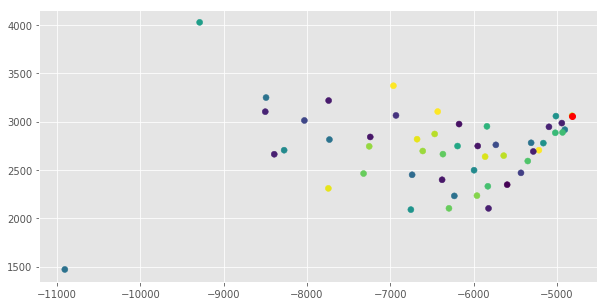

In [3]:
colors = np.random.rand(len(nodes.index))
plt.scatter(nodes['x'].values, nodes['y'].values, c=colors)
plt.plot(nodes.loc['Augusta, Maine', 'x'], nodes.loc['Augusta, Maine', 'y'], 'ro')
plt.show()

We can see Hawaii is on the left bottom corner and Alaska on the left up corner.

Augusta is Highlighted in red, which will be used as the starting point in this tutorial.

We use the complete graph, which means each pair of vertices is connected by an edge. In this tutorial, we use the Euclidean distance as cost.

In [4]:
def get_edges(nodes):
    """
    create a complete graph from a list of nodes
        
    Args:
        nodes: list of nodes
    Returns:
        edges: list of edges
    """
    # an edge connects two nodes with a cost
    data = {'from': [], 'to': [], 'cost': []}
    for i in nodes.index:
        for j in nodes.index:
            if i != j:
                # we use the Euclidean distance
                dx = nodes.loc[i, 'x'] - nodes.loc[j, 'x']
                dy = nodes.loc[i, 'y'] - nodes.loc[j, 'y']
                d = math.sqrt(dx * dx + dy * dy)
                data['from'].append(i)
                data['to'].append(j)
                data['cost'].append(d)
    edges = pd.DataFrame(data=data, columns=['from', 'to', 'cost'])
    return edges

edges = get_edges(nodes)
edges.head()

,from,to,cost
0,"Montgomery, Alabama","Juneau, Alaska",3778.480316
1,"Montgomery, Alabama","Phoenix, Arizona",1783.885334
2,"Montgomery, Alabama","Little Rock, Arkansas",449.200825
3,"Montgomery, Alabama","Sacramento, California",2468.842413
4,"Montgomery, Alabama","Denver, Colorado",1389.335431


## Minimum Spanning Tree

Before we try to find a solution, let's look into Minimum Spanning Tree(MST) problem. A minimum spanning tree is a subset of the edges of a connected, edge-weighted (un)directed graph that connects all the vertices together, without any cycles and with the minimum possible total edge weight. That is, it is a spanning tree whose sum of edge weights is as small as possible.

An example is given as below:

[<img src="https://s3.amazonaws.com/learneroo-images/main/Minimum_spanning_tree.png">](https://s3.amazonaws.com/learneroo-images/main/Minimum_spanning_tree.png)

There are three algorithms that could produce a Minimum Spanning tree.

### 1 Prim's Algorithm

Start with a root node s and try to greedily grow a tree from s outward. at each step, we simply add the node that can be attached as cheaply as possible to the partial tree we already have.

### 2 Kruskal's Algorithm

Start without any edges at all and builds a spanning tree by successively inserting edges from E in order of increasing cost. As we move through the edges in this order, we insert each edge e as long as it does not create a cycle when added to the edges we've already inserted. If, on the other hand, inserting e would result in a cycle, then we can simply discard e and continue.

### 3 Reverse-Delete Algorithm

Start with the full graph (V, E) and begin deleting edges in order of decreasing cost. As we get to each edge e (starting from the most expensive), we delete it as long as doing so would not actually disconnect the graph we currently have.

The algorithm that will be implemented is Kruskal's Algorithm.

### Union Find

To implement Kruskal's Algorithm, we need to define a data structure that could find the set of connected components. In this tutorial, we will use the Union-Find structure, which will store a representation of the components in a way that supports rapid searching and updating.

The Union-Find abstract data type supports the following operations that maintain a collection of sets of elements:

    MakeUnionfind(S) - create the data structure containing |S| sets, each contains one item from S.
    
    Find(i) - return the "name" of the set containing item i.
    
    Union(a, b) - merge the sets with names a and b into a single set.

In [5]:
class UnionFind:
    def __init__(self, nodes):
        """
        Initialize an union find object.
        
        Args:
            nodes: list of nodes
        """
        self.items = pd.DataFrame()
        self.items['name'] = nodes.index
        self.items['set'] = nodes.index
        self.items['size'] = 1
        self.items = self.items.set_index('name')
    
    def find(self, node):
        """
        find the set name of a node

        Args:
            node: node to find
        Returns:
            name: name of the set that contains node
        """
        if node == None or not node in self.items.index:
            return None
        curr = node
        while True:
            if not curr in self.items.index:
                return None
            if curr == self.items.loc[curr, 'set']:
                return curr
            curr = self.items.loc[curr, 'set']
    
    def union(self, na, nb):
        """
        union two nodes

        Args:
            na: node a
            nb: node b
        """
        if na == None or not na in self.items.index:
            return
        if nb == None or not nb in self.items.index:
            return
        ia = self.find(na)
        ib = self.find(nb)
        if self.items.loc[ia, 'size'] < self.items.loc[ib, 'size']:
            self.items.loc[ia, 'set'] = ib
            self.items.loc[ib, 'size'] = self.items.loc[ia, 'size'] + self.items.loc[ib, 'size']
        else:
            self.items.loc[ib, 'set'] = ia
            self.items.loc[ia, 'size'] = self.items.loc[ia, 'size'] + self.items.loc[ib, 'size']


Note that when merging two sets, we merge the one with smaller size to the one with bigger size. Doing so will avoid making the tree too 'deep'.

A simple demo of Union-Find gives as below:

Initially, [a, b, c, d] are in four separate set.

Then we union a and b, c and d, and finally a and c.

In [6]:
# n is a set of 4 items
n = pd.DataFrame({'name': ['a','b','c','d']}).set_index('name')

uf = UnionFind(n)
print("before any union")
for i in uf.items.index:
    print(i, "is in set", uf.find(i), "and the size of", uf.find(i), "is", uf.items.loc[uf.find(i), 'size'])
print("let's union a and b")
uf.union('a', 'b')
for i in uf.items.index:
    print(i, "is in set", uf.find(i), "and the size of", uf.find(i), "is", uf.items.loc[uf.find(i), 'size'])
print("let's union c and d")
uf.union('c', 'd')
for i in uf.items.index:
    print(i, "is in set", uf.find(i), "and the size of", uf.find(i), "is", uf.items.loc[uf.find(i), 'size'])
print("let's union a and c")
uf.union('a', 'c')
for i in uf.items.index:
    print(i, "is in set", uf.find(i), "and the size of", uf.find(i), "is", uf.items.loc[uf.find(i), 'size'])

before any union
a is in set a and the size of a is 1
b is in set b and the size of b is 1
c is in set c and the size of c is 1
d is in set d and the size of d is 1
let's union a and b
a is in set a and the size of a is 2
b is in set a and the size of a is 2
c is in set c and the size of c is 1
d is in set d and the size of d is 1
let's union c and d
a is in set a and the size of a is 2
b is in set a and the size of a is 2
c is in set c and the size of c is 2
d is in set c and the size of c is 2
let's union a and c
a is in set a and the size of a is 4
b is in set a and the size of a is 4
c is in set a and the size of a is 4
d is in set a and the size of a is 4


### Kruskal's Algorithm

In [7]:
class MST:
    def __init__(self, nodes, edges):
        """
        Initialize an MST
        
        Args:
            nodes: list of nodes
            edges: list of edges
        """
        self.nodes = nodes
        self.edges = edges
        tree_edges = {'from':[], 'to':[]}
        uf = UnionFind(nodes)
        for i in self.edges.sort_values(by=['cost']).index:
            if uf.find(self.edges.loc[i, 'from']) != uf.find(self.edges.loc[i, 'to']):
                uf.union(uf.find(self.edges.loc[i, 'from']), uf.find(self.edges.loc[i, 'to']))
                tree_edges['from'].append(self.edges.loc[i, 'from'])
                tree_edges['to'].append(self.edges.loc[i, 'to'])
        self.tree = pd.DataFrame(data=tree_edges, columns=['from', 'to'])
        
    def get_edges(self):
        """
        get the tree edges

        Returns:
            tree: tree edges
        """
        return self.tree
        

### Visualize result

Let's assume that the cost of edges is the Euclidean distance. This is valid because the airline route is roughly a straight line between cities.

The Minimum Spanning tree is shown as below:

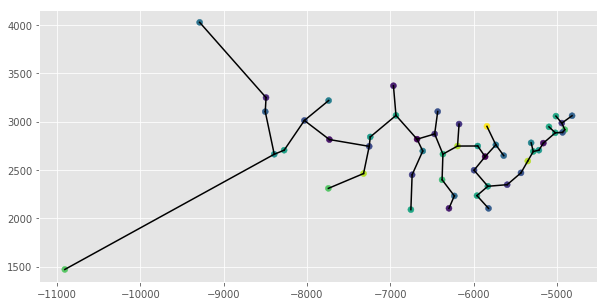

In [8]:
def visualize_result(nodes, edges):
    """
    visualize the result

    Args:
        nodes: list of nodes
        edges: list of edges
    """
    colors = np.random.rand(len(nodes.index))
    plt.scatter(nodes['x'].values, nodes['y'].values, c=colors)
    for e in edges.index:
        trace = {'x':[], 'y':[]}
        trace['x'].append(nodes.loc[edges.loc[e, 'from'], 'x'])
        trace['x'].append(nodes.loc[edges.loc[e, 'to'], 'x'])
        trace['y'].append(nodes.loc[edges.loc[e, 'from'], 'y'])
        trace['y'].append(nodes.loc[edges.loc[e, 'to'], 'y'])
        plt.plot(trace['x'], trace['y'], 'k-')
    plt.show()

mst = MST(nodes, edges)
visualize_result(nodes, mst.get_edges())

## Travelling Salesman Problem

The traveling salesman problem(TSP) was defined in the 1800s by the Irish mathematician W. R. Hamilton and by the British mathematician Thomas Kirkman. The general form of the TSP appears to have been first studied by mathematicians during the 1930s in Vienna and at Harvard, notably by Karl Menger. 

TSP is a classic NP-hard problem, which means it can not be solved in polynomial time complexity. If there is a way to break this problem into smaller component problems, the components will be at least as complex as the original one.

Here's a solution to 48 States Traveling Salesman Problem from https://optimization.mccormick.northwestern.edu/index.php/Traveling_salesman_problems
[<img src="https://optimization.mccormick.northwestern.edu/images/e/ea/48StatesTSP.png">](https://optimization.mccormick.northwestern.edu/images/e/ea/48StatesTSP.png)

Using brute force search, we could try all permutations and see which one is cheapest. The running time for this approach lies within a polynomial factor of O(n!), which is impractical when n is larger than 20.

One of the earliest applications of dynamic programming is the Held–Karp algorithm that solves the problem in time O(n^2*2^n)

Other approaches include using branch-and-bound algorithms(for 40-60 cities); Progressive improvement algorithms which use techniques reminiscent of linear programming(for up to 200 cities); Branch-and-bound and problem-specific cut generation. This approach holds the current record, solving an instance with 85,900 cities.

However, in some scenarios, we do not actually require a strict optimal solution(like the graduation trip example in this tutorial). Therefore we could use heuristics approaches to find a useful solution in a fraction of the time required for a full brute force of the problem.

Modern heuristics and approximation algorithms can find solutions for extremely large problems (millions of cities) within a reasonable time which are with a high probability just 2-3% away from the optimal solution.

In this tutorial, we will use MST to construct a route which is promised to be less than double the cost of an optimal solution, and try to optimize it with heuristics.

### Approximation Algorithm

In computer science and operations research, Approximation Algorithm is a way to find efficient approximate solutions to NP-hard optimization problems with provable guarantees on the distance of the returned solution to the optimal one.

For this problem, we will use MST to construct a TSP Approximation Algorithm. The algorithm is described as:

    1. Compute a minimum spanning tree T connecting the cities.
    
    2. Visit the cities in order of a preorder traversal of T.

(Preorder traversal = visit a node, then the entire subtree of its first child, then the entire subtree of the second child, etc.)

### Prove

It can be proved that this algorithm cost no more than twice as the optimal solution.

Let's define the total cost of an MST as B, the total cost of the optimal solution as OPT, and the total cost of our approximation algorithm as A.

It's not hard to see that, by definition, B is the minimum cost for any subset of the graph that connects all nodes. Thus, the optimal route OPT must be greater or equal to B. Using triangle inequality, it can also be proved that A is less than 2 * B. Thus, we can prove:

    A < 2 * B < 2 * OPT

A simple example is given:

First, we have a graph with 7 nodes and 9 edges(cost are hidden).

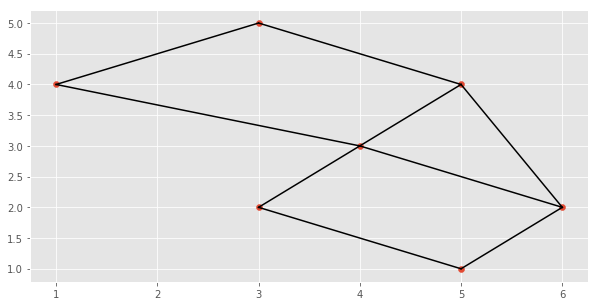

In [9]:
plt.scatter([3, 1, 5, 4, 3, 6, 5], [5, 4, 4, 3, 2, 2, 1])
plt.plot([3,1], [5,4], 'k')
plt.plot([3,5], [5,4], 'k')
plt.plot([1,4], [4,3], 'k')
plt.plot([5,4], [4,3], 'k')
plt.plot([4,3], [3,2], 'k')
plt.plot([4,6], [3,2], 'k')
plt.plot([3,5], [2,1], 'k')
plt.plot([6,5], [2,1], 'k')
plt.plot([5,6], [4,2], 'k')
plt.show()

The MST of the graph is shown in red:

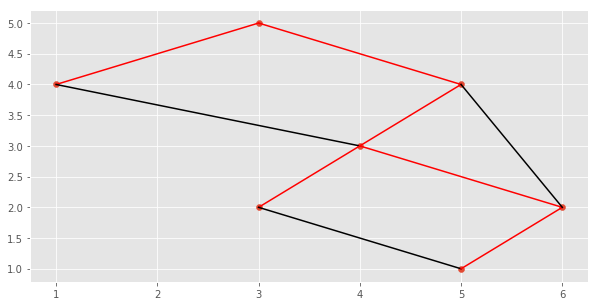

In [10]:
plt.scatter([3, 1, 5, 4, 3, 6, 5], [5, 4, 4, 3, 2, 2, 1])
plt.plot([3,1], [5,4], 'r')
plt.plot([3,5], [5,4], 'r')
plt.plot([1,4], [4,3], 'k')
plt.plot([5,4], [4,3], 'r')
plt.plot([4,3], [3,2], 'r')
plt.plot([4,6], [3,2], 'r')
plt.plot([3,5], [2,1], 'k')
plt.plot([6,5], [2,1], 'r')
plt.plot([5,6], [4,2], 'k')
plt.show()

The preorder traversal is shown in blue:

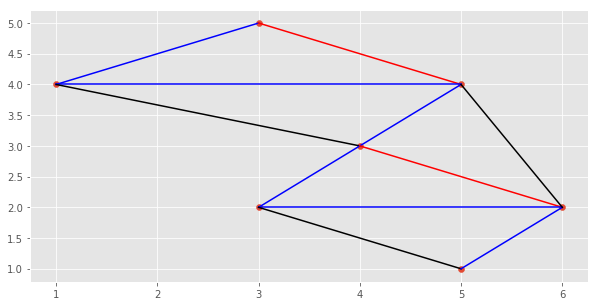

In [11]:
plt.scatter([3, 1, 5, 4, 3, 6, 5], [5, 4, 4, 3, 2, 2, 1])
plt.plot([3,1], [5,4], 'b')
plt.plot([3,5], [5,4], 'r')
plt.plot([1,5], [4,4], 'b')
plt.plot([1,4], [4,3], 'k')
plt.plot([5,4], [4,3], 'b')
plt.plot([4,3], [3,2], 'b')
plt.plot([4,6], [3,2], 'r')
plt.plot([3,6], [2,2], 'b')
plt.plot([3,5], [2,1], 'k')
plt.plot([6,5], [2,1], 'b')
plt.plot([5,6], [4,2], 'k')
plt.show()

### Implementation of TSP

In our TSP, the graph is an undirected graph. We implemented by creating two directed edges from both sides for any edges.

In [12]:
class TSP:
    def __init__(self, mst):
        """
        Initialize an TSP
        
        Args:
            mst: minimum spanning tree
        """
        self.nodes = mst.nodes
        self.edges_ud = {}
        self.weights = {}
        for n in mst.nodes.index:
            self.edges_ud[n] = []
        for i in mst.tree.index:
            self.edges_ud[mst.tree.loc[i, 'from']].append(mst.tree.loc[i, 'to'])
            self.edges_ud[mst.tree.loc[i, 'to']].append(mst.tree.loc[i, 'from'])
            
    def get_path(self, start):
        """
        get the proorder of mst
        
        Args:
            start: starting point

        Returns:
            tree: tree edges
        """
        stack = []
        path = []
        stack.append(start)
        while len(stack) != 0:
            city = stack.pop()
            path.append(city)
            next_citys = self.edges_ud[city]
            for c in next_citys:
                if c not in path:
                    stack.append(c)
        data = {'from':[], 'to':[]}
        for i in range(len(path)-1):
            data['from'].append(path[i])
            data['to'].append(path[i+1])
        return pd.DataFrame(data=data, columns=['from', 'to'])
    
    def opt_path(self, start):
        """
        get the optimized path
        
        Args:
            start: starting point

        Returns:
            tree: tree edges
        """
        edges_d = {}
        stack = []
        stack.append(start)
        while len(stack) != 0:
            node = stack.pop()
            edges_d[node] = []
            connect_nodes = self.edges_ud[node]
            for c in connect_nodes:
                if c not in edges_d:
                    edges_d[node].append(c)
                    stack.append(c)
        self.get_weight(edges_d, start)
        stack = []
        path = []
        stack.append(start)
        while len(stack) != 0:
            city = stack.pop()
            path.append(city)
            if city in edges_d:
                next_citys = edges_d[city]
                next_citys = sorted(next_citys, key=lambda c: -1 * self.get_distance(city, c))
                for c in next_citys:
                    stack.append(c)
        data = {'from':[], 'to':[]}
        for i in range(len(path)-1):
            data['from'].append(path[i])
            data['to'].append(path[i+1])
        return pd.DataFrame(data=data, columns=['from', 'to'])
        
        
    def get_weight(self, edges_d, node):
        """
        get the everage coordinate of a node and set all sub-tree of the node
        
        Args:
            edges_d: directed edges
            node: node
        """
        if not node in edges_d:
            self.wieghts[node] = {'number': 1, 'x': self.nodes.loc[node, 'x'], 'y': self.nodes.loc[node, 'y']}
            return
        connect_nodes = edges_d[node]
        number = 1;
        x = self.nodes.loc[node, 'x']
        y = self.nodes.loc[node, 'y']
        for cn in connect_nodes:
            self.get_weight(edges_d, cn)
            weight = self.weights[cn]
            number = number + weight['number']
            x = x + weight['x'] * weight['number']
            y = y + weight['y'] * weight['number']
        x = x / number
        y = y / number
        self.weights[node] = {'number': number, 'x': x, 'y': y}
    
    def get_distance(self, na, nb):
        """
        get the distance for two nodes
        
        Args:
            na: node a
            nb: node b

        Returns: distance
        """
        dx = self.nodes.loc[na, 'x'] - self.weights[nb]['x']
        dy = self.nodes.loc[na, 'y'] - self.weights[nb]['y']
        return math.sqrt(dx * dx + dy * dy)


### Result

Let's set our starting city Augusta, the result is shown below:

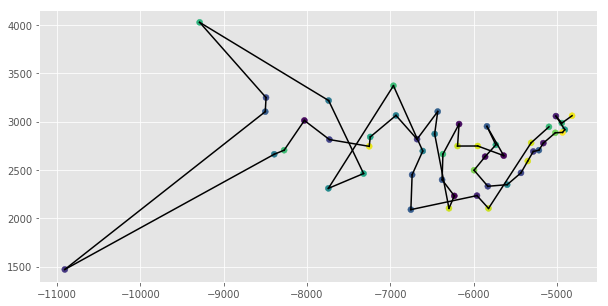

In [13]:
tsp = TSP(mst)
path = tsp.get_path( 'Augusta, Maine')

visualize_result(nodes, path)

Not looks good? It's because of right now we just randomly choose a branch when we have many options to choose. Thus we may go too far in one branch and come back after a long trip. As you may notice, if we follow this route, we will visit Alaska and Hawaii before we come to Harrisburg.

## Optimization

We could optimize it with some heuristics. Instead of randomly choosing a branch, we can use the average coordinate of the branches and sort them in ascending order, then we traverse from the least. It works because of we will traverse cities that are closer to us, and reduce the total cost.

The result is shown below:

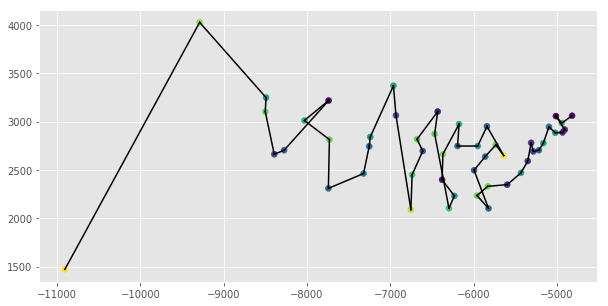

In [14]:
tsp = TSP(mst)
path = tsp.opt_path('Augusta, Maine')

visualize_result(nodes, path)

### Analysis

The total cost of the previous method is 23004.3 while the total cost of the optimized method is16961.6. We can see a significant improvement in efficiency. Unfortunately, the optimal solution is hard to calculate. So, we are not able to compare our result to the optimal one.

In [15]:
def total_cost(nodes, path):
    """
    get the total cost

    Args:
        nodes: list of nodes
        path: path
    Returns: total cost
    """
    total = 0
    for i in path.index:
        dx = nodes.loc[path.loc[i, 'from'], 'x'] - nodes.loc[path.loc[i, 'to'], 'x']
        dy = nodes.loc[path.loc[i, 'from'], 'y'] - nodes.loc[path.loc[i, 'to'], 'y']
        total = total + math.sqrt(dx*dx + dy*dy)
    return total

print(total_cost(nodes, tsp.get_path('Augusta, Maine')))
print(total_cost(nodes, tsp.opt_path('Augusta, Maine')))

23004.300921540686
16961.63460543226


## Summary

This tutorial introduced the concept of minimum spanning tree and showed one application in solving the traveling salesman problem. 

For more information, the book Algorithm Design is highy recommended. And there is fun web that you can play with TSP - The Traveling Salesman Problem with integer programming and Gurobi(http://examples.gurobi.com/traveling-salesman-problem/)

## Reference
1. Traveling salesman problem: https://simple.wikipedia.org/wiki/Travelling_salesman_problem
2. Minimum spanning tree: https://en.wikipedia.org/wiki/Minimum_spanning_tree
3. Algorithm Design - Jon Kleinberg and ´Eva Tardos
4. Slides from professor Jian Ma (course 02613)
5. CITIES City Distance Datasets: https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html